<a href="https://colab.research.google.com/github/fcoliveira-utfpr/agrometeorologia/blob/main/02_climogramas_br.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Início - Bibliotecas**
---

In [42]:
#importando bibliotecas
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from google.colab import files
import matplotlib.pyplot as plt
!pip install rasterio matplotlib geopandas geobr   -q
import geopandas as gpd
from geobr import read_state
import matplotlib as mpl
import matplotlib.colors as colors
from geobr import read_municipality
import folium
import branca.colormap as cm
%matplotlib inline
%config inlineBackend.figure_formats = ['svg']

# **Dados climograma**
---

In [4]:
municipio = "Santa Maria" ###### Nome aqui entre aspas

estado = "RS" ###### Sigla do estado entre aspas

# ============================================================
# Carrega base climática local
# ============================================================
url_1 = "https://raw.githubusercontent.com/fcoliveira-utfpr/agrometeorologia/refs/heads/main/clima_solo_local.csv"
df1 = pd.read_csv(url_1)

url_2 = "https://raw.githubusercontent.com/fcoliveira-utfpr/agrometeorologia/refs/heads/main/TerraClimate_PR_PET_Normal_1991_2020.csv"
df2 = pd.read_csv(url_2)

# Separa colunas categóricas
cidade = df1['Município']
uf = df1['Estado']
regiao = df1['Região']
koppen = df1['Köppen']

cidade2 = df2['Município']
uf2 = df2['Estado']

# Converte valores com vírgula para ponto e numérico
df1_valores = df1.drop(columns=['Município', 'Estado','Região','Köppen'])
df1_valores = df1_valores.replace({',': '.'}, regex=True)
df1_valores = df1_valores.apply(pd.to_numeric, errors='coerce')

df_valores2 = df2.drop(columns=['Município', 'Estado'])
df_valores2 = df_valores2.replace({',': '.'}, regex=True)
df_valores2 = df_valores2.apply(pd.to_numeric, errors='coerce')

# Reconstrói o df
df1 = df1_valores.copy()
df1['Município'] = cidade
df1['Estado'] = uf
df1['Região'] = regiao
df1['Köppen'] = koppen

df2 = df_valores2.copy()
df2['Município'] = cidade2
df2['Estado'] = uf2

# Filtra município e estado
df11 = df1[(df1['Município'] == municipio) & (df1['Estado'] == estado)].copy()
df22 = df2[(df2['Município'] == municipio) & (df2['Estado'] == estado)].copy()

meses = ["jan","fev","mar","abr","maio","jun","jul","ago","set","out","nov","dez"]

temp = [df1[f"T_{m}"].values[0] for m in meses]

mese = [f"{i:02d}" for i in range(1, 13)]

pet = [df2[f"PET_{m}"].values[0] for m in mese]
chuva = [df2[f"PR_{m}"].values[0] for m in mese]

meses = ["jan","fev","mar","abr","maio","jun","jul","ago","set","out","nov","dez"]

#Visualizar dados e baixar
df6 = pd.DataFrame(
    {
        "Mês": meses,
        "Temperatura média (°C)": temp,
        "Chuva (mm/mês)": chuva,
        "ETP (mm/mês)": pet
    }
)
df6["Município"] = municipio

tiempo = 'dados_climograma'

#para baixar os dados tire o # da última linha
from google.colab import files
df6.to_excel(f'{municipio}_{tiempo}.xlsx')
#files.download(f'{municipio}_{tiempo}.xlsx')

df6

Mês  Temperatura média (°C)  Chuva (mm/mês)  ETP (mm/mês)    Município
0    jan                    26.2      258.566667     83.906667  Santa Maria
1    fev                    26.4      247.733333     79.573333  Santa Maria
2    mar                    26.3      241.900000     86.810000  Santa Maria
3    abr                    25.5      109.733333     90.463333  Santa Maria
4   maio                    23.8       58.433333     88.580000  Santa Maria
5    jun                    22.8       19.600000     91.956667  Santa Maria
6    jul                    22.8        6.066667    113.706667  Santa Maria
7    ago                    24.6       18.600000    132.893333  Santa Maria
8    set                    25.8       62.966667    123.050000  Santa Maria
9    out                    27.0      140.100000    119.883333  Santa Maria
10   nov                    27.1      169.866667     98.523333  Santa Maria
11   dez                    26.7      210.133333     91.566667  Santa Maria

# Gráfico **Climograma**
---

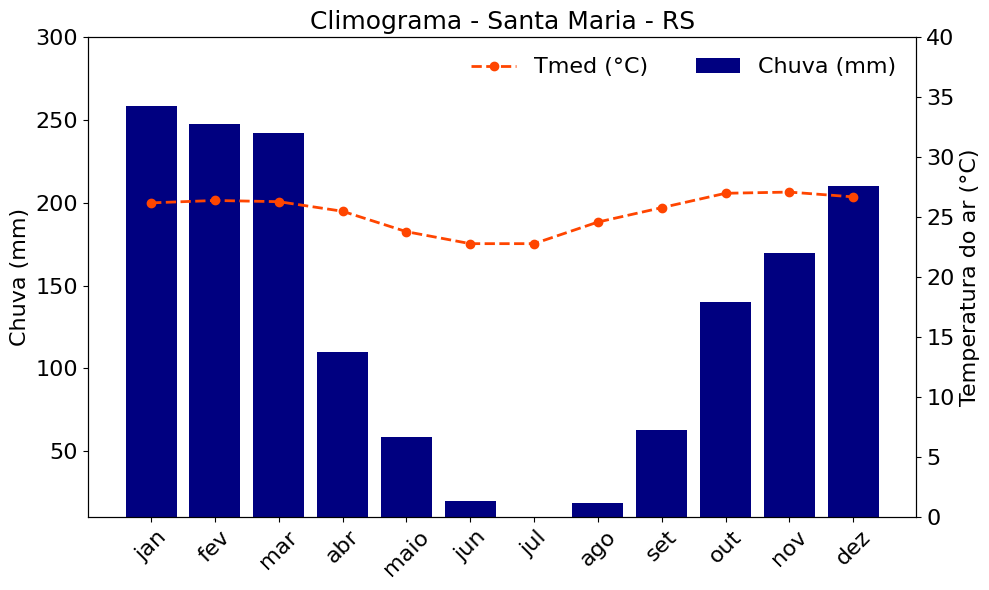

In [5]:
figs, axs = plt.subplots(figsize=(10, 6))

x = meses

axs.bar(x, chuva, color='navy', label='Chuva (mm)')
axs.set_title(f'Climograma - {municipio} - {estado}', fontsize=18)
axs.set_ylabel('Chuva (mm)', fontsize=16)

# X e Y ticks
axs.tick_params(axis='x', which='major', labelsize=16, rotation=45)
axs.tick_params(axis='y', which='major', labelsize=16)

axs.set_ylim([10, 300])
axs.legend(frameon=False, fontsize=16, ncol=2, bbox_to_anchor=(1, 1))

# Segundo eixo
axs2 = axs.twinx()
axs2.plot(
    x, temp,
    marker='o',
    color='orangered',
    linewidth=2,
    linestyle='--',
    label='Tmed (°C)'
)

axs2.tick_params(axis='y', which='major', labelsize=16)
axs2.set_ylim([0, 40])
axs2.set_ylabel('Temperatura do ar (°C)', fontsize=16)
axs2.legend(frameon=False, fontsize=16, ncol=2, bbox_to_anchor=(0.7, 1))

plt.tight_layout()
plt.show()

# Mapa da chuva por estado
---

## Mapa de chuva estático

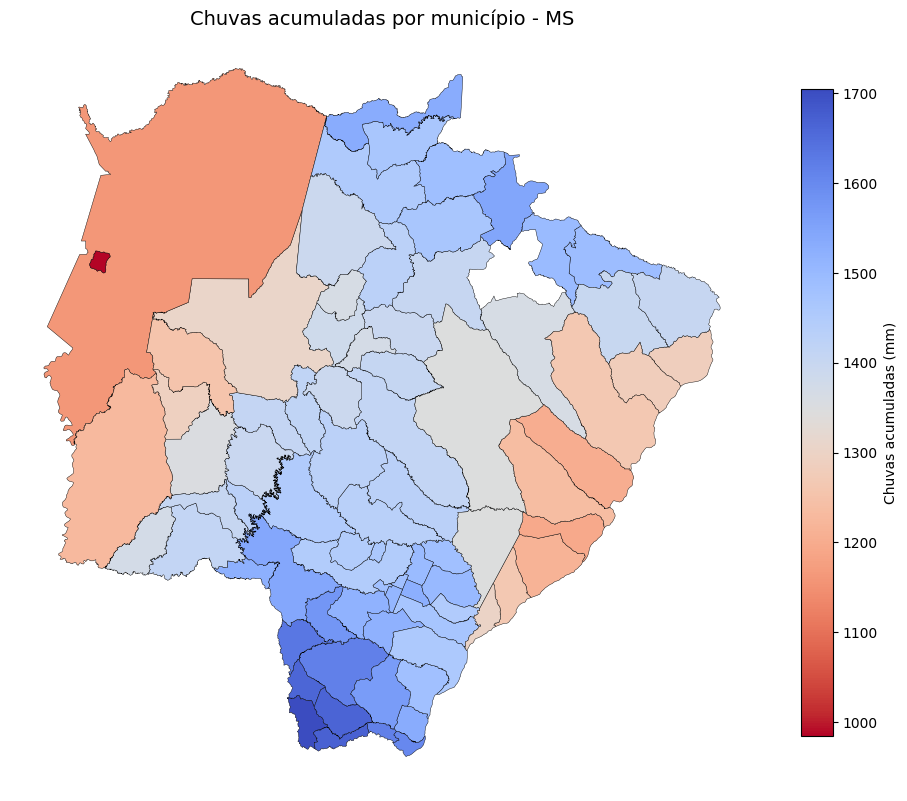

In [51]:
# ============================================================
estado = "MS"   # AC, AL, AM, BA, CE, DF, ES, GO, MA, MG, MS, MT,
                # PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO
# ============================================================

url_2 = "https://raw.githubusercontent.com/fcoliveira-utfpr/agrometeorologia/refs/heads/main/TerraClimate_PR_PET_Normal_1991_2020.csv"
df2 = pd.read_csv(url_2)

cidade2 = df2['Município']
uf2 = df2['Estado']

df_valores2 = df2.drop(columns=['Município', 'Estado'])
df_valores2 = df_valores2.replace({',': '.'}, regex=True)
df_valores2 = df_valores2.apply(pd.to_numeric, errors='coerce')

df2 = df_valores2.copy()
df2['Município'] = cidade2
df2['Estado'] = uf2

df22 = df2[(df2['Estado'] == estado)].copy()

# Colunas de chuva
colunas_chuva = [f'PR_{str(i).zfill(2)}' for i in range(1, 13)]
df22['chuvas_sum'] = df22[colunas_chuva].sum(axis=1)

# ============================================================
# Ler shapefile dos municípios do estado
# ============================================================
municipios = read_municipality(code_muni=estado, year=2020)

# Padronizar nomes (evita erro de merge)
municipios['name_muni'] = municipios['name_muni'].str.upper().str.strip()
df22['Município'] = df22['Município'].str.upper().str.strip()

# ============================================================
# Merge espacial (atributos + geometria)
# ============================================================
gdf = municipios.merge(
    df22,
    left_on='name_muni',
    right_on='Município',
    how='left'
)

# ============================================================
# Plot coroplético
# ============================================================
fig, ax = plt.subplots(figsize=(12, 12))

cmap = mpl.colormaps['coolwarm'].reversed()
norm = colors.Normalize(vmin=gdf['chuvas_sum'].min(), vmax=gdf['chuvas_sum'].max())

gdf.plot(
    column='chuvas_sum',
    cmap=cmap,
    linewidth=0.3,
    edgecolor='black',
    legend=True,
    ax=ax,
    norm=norm,
    legend_kwds={
        'label': 'Chuvas acumuladas (mm)',
        'shrink': 0.7
    }
)

ax.set_title(f"Chuvas acumuladas por município - {estado}", fontsize=14)
ax.set_axis_off()

plt.show()


## Mapa de chuva dinâmico

In [52]:
# ============================================================
estado = "MT"   # AC, AL, AM, BA, CE, DF, ES, GO, MA, MG, MS, MT,
                # PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO
# ============================================================

url_2 = "https://raw.githubusercontent.com/fcoliveira-utfpr/agrometeorologia/refs/heads/main/TerraClimate_PR_PET_Normal_1991_2020.csv"
df2 = pd.read_csv(url_2)

cidade2 = df2['Município']
uf2 = df2['Estado']

df_valores2 = df2.drop(columns=['Município', 'Estado'])
df_valores2 = df_valores2.replace({',': '.'}, regex=True)
df_valores2 = df_valores2.apply(pd.to_numeric, errors='coerce')

df2 = df_valores2.copy()
df2['Município'] = cidade2
df2['Estado'] = uf2

df22 = df2[(df2['Estado'] == estado)].copy()

# Colunas de chuva
colunas_chuva = [f'PR_{str(i).zfill(2)}' for i in range(1, 13)]
df22['chuvas_sum'] = df22[colunas_chuva].sum(axis=1)

# ============================================================
# Ler shapefile dos municípios do estado
# ============================================================
municipios = read_municipality(code_muni=estado, year=2020)

# Padronizar nomes (evita erro de merge)
municipios['name_muni'] = municipios['name_muni'].str.upper().str.strip()
df22['Município'] = df22['Município'].str.upper().str.strip()

# ============================================================
# Merge espacial (atributos + geometria)
# ============================================================
gdf = municipios.merge(
    df22,
    left_on='name_muni',
    right_on='Município',
    how='left'
)

# ============================================================
# Projeta temporariamente para CRS métrico
# ============================================================
gdf_proj = gdf.to_crs(epsg=3857)  # Web Mercator (metros)

# ============================================================
# Calcula centróide corretamente
# ============================================================
centro = gdf_proj.geometry.centroid
lat_centro = centro.to_crs(epsg=4326).y.mean()
lon_centro = centro.to_crs(epsg=4326).x.mean()

# ============================================================
# Volta para EPSG:4326 (Folium)
# ============================================================
gdf_folium = gdf.to_crs(epsg=4326)

# ============================================================
# Mapa
# ============================================================
m = folium.Map(
    location=[lat_centro, lon_centro],
    zoom_start=6,
    tiles='CartoDB positron'
)

# ============================================================
# Colormap dinâmico
# ============================================================
vmin = gdf_folium['chuvas_sum'].min()
vmax = gdf_folium['chuvas_sum'].max()

colormap = cm.LinearColormap(
    colors=['red', 'orange', 'yellow', 'cyan', 'blue'],
    vmin=vmin,
    vmax=vmax,
    caption=f'Chuvas acumuladas (mm) – {estado}'
)

# ============================================================
# Estilo do polígono
# ============================================================
def style_function(feature):
    valor = feature['properties']['chuvas_sum']
    return {
        'fillColor': colormap(valor) if valor is not None else '#dddddd',
        'color': 'black',
        'weight': 0.4,
        'fillOpacity': 0.8,
    }

# ============================================================
# Camada GeoJson + Tooltip
# ============================================================
folium.GeoJson(
    gdf_folium,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['name_muni', 'chuvas_sum'],
        aliases=['Município:', 'Chuva acumulada (mm):'],
        localize=True,
        sticky=True
    )
).add_to(m)

# ============================================================
# Legenda
# ============================================================
colormap.add_to(m)

m


# Mapa da temperatura por estado
---

## Mapa de temperatura estático

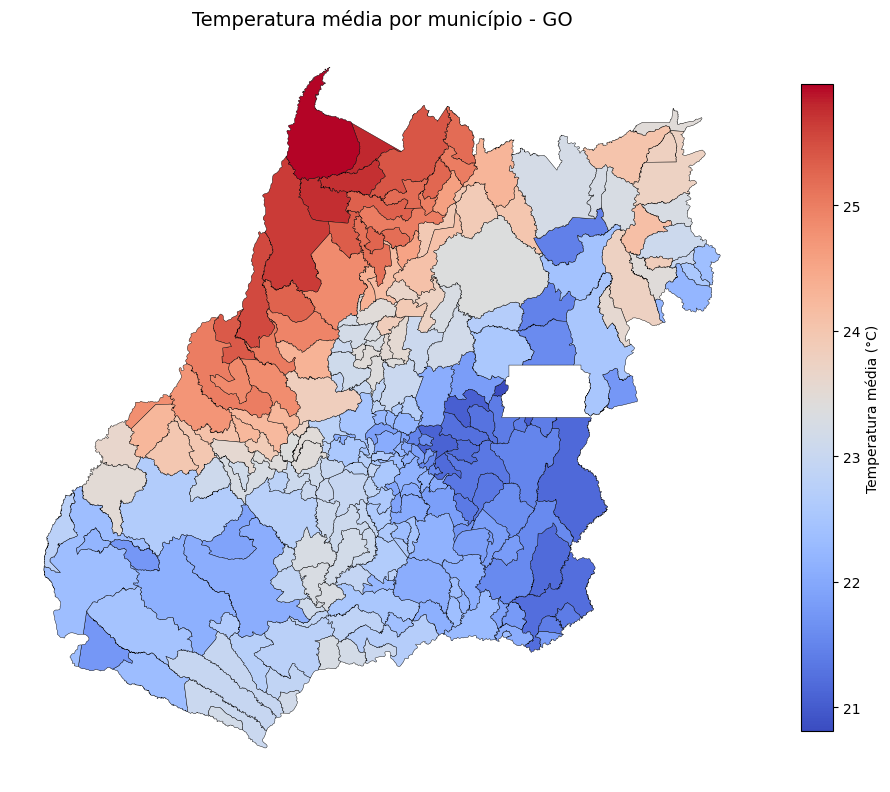

In [53]:
# ============================================================
estado = "GO"   # AC, AL, AM, BA, CE, DF, ES, GO, MA, MG, MS, MT,
                # PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO
# ============================================================

url_1 = "https://raw.githubusercontent.com/fcoliveira-utfpr/agrometeorologia/refs/heads/main/clima_solo_local.csv"
df1 = pd.read_csv(url_1)

# Separa colunas categóricas
cidade = df1['Município']
uf = df1['Estado']
regiao = df1['Região']
koppen = df1['Köppen']

# Converte valores com vírgula para ponto e numérico
df1_valores = df1.drop(columns=['Município', 'Estado','Região','Köppen'])
df1_valores = df1_valores.replace({',': '.'}, regex=True)
df1_valores = df1_valores.apply(pd.to_numeric, errors='coerce')

# Reconstrói o df
df1 = df1_valores.copy()
df1['Município'] = cidade
df1['Estado'] = uf
df1['Região'] = regiao
df1['Köppen'] = koppen

# Filtra df1 para incluir todos os municípios do estado selecionado
df_estado_temp = df1[df1['Estado'] == estado].copy()

# Colunas de temperatura
meses = ["jan","fev","mar","abr","maio","jun","jul","ago","set","out","nov","dez"]
temp_cols = [f"T_{m}" for m in meses] # Criar lista de nomes de colunas de temperatura

# Calcular a temperatura média anual para cada município no estado
df_estado_temp['Tmed'] = df_estado_temp[temp_cols].mean(axis=1)

# ============================================================
# Ler shapefile dos municípios do estado
# ============================================================
municipios = read_municipality(code_muni=estado, year=2020)

# Padronizar nomes (evita erro de merge)
municipios['name_muni'] = municipios['name_muni'].str.upper().str.strip()
df_estado_temp['Município'] = df_estado_temp['Município'].str.upper().str.strip()

# ============================================================
# Merge espacial (atributos + geometria)
# ============================================================
gdf = municipios.merge(
    df_estado_temp,
    left_on='name_muni',
    right_on='Município',
    how='left'
)

# ============================================================
# Plot coroplético
# ============================================================
fig, ax = plt.subplots(figsize=(12, 12))

cmap = mpl.colormaps['coolwarm']
norm = colors.Normalize(vmin=gdf['Tmed'].min(), vmax=gdf['Tmed'].max())

gdf.plot(
    column='Tmed',
    cmap=cmap,
    linewidth=0.3,
    edgecolor='black',
    legend=True,
    ax=ax,
    norm=norm,
    legend_kwds={
        'label': 'Temperatura média (°C)',
        'shrink': 0.7
    }
)

ax.set_title(f"Temperatura média por município - {estado}", fontsize=14)
ax.set_axis_off()

plt.show()

## Mapa de temperatura dinâmico

In [54]:
# ============================================================
estado = "RS"   # AC, AL, AM, BA, CE, DF, ES, GO, MA, MG, MS, MT,
                # PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO
# ============================================================

url_1 = "https://raw.githubusercontent.com/fcoliveira-utfpr/agrometeorologia/refs/heads/main/clima_solo_local.csv"
df1 = pd.read_csv(url_1)

# Separa colunas categóricas
cidade = df1['Município']
uf = df1['Estado']
regiao = df1['Região']
koppen = df1['Köppen']

# Converte valores com vírgula para ponto e numérico
df1_valores = df1.drop(columns=['Município', 'Estado','Região','Köppen'])
df1_valores = df1_valores.replace({',': '.'}, regex=True)
df1_valores = df1_valores.apply(pd.to_numeric, errors='coerce')

# Reconstrói o df
df1 = df1_valores.copy()
df1['Município'] = cidade
df1['Estado'] = uf
df1['Região'] = regiao
df1['Köppen'] = koppen

# Filtra df1 para incluir todos os municípios do estado selecionado
df_estado_temp = df1[df1['Estado'] == estado].copy()

# Colunas de temperatura
meses = ["jan","fev","mar","abr","maio","jun","jul","ago","set","out","nov","dez"]
temp_cols = [f"T_{m}" for m in meses] # Criar lista de nomes de colunas de temperatura

# Calcular a temperatura média anual para cada município no estado
df_estado_temp['Tmed'] = df_estado_temp[temp_cols].mean(axis=1)

# ============================================================
# Ler shapefile dos municípios do estado
# ============================================================
municipios = read_municipality(code_muni=estado, year=2020)

# Padronizar nomes (evita erro de merge)
municipios['name_muni'] = municipios['name_muni'].str.upper().str.strip()
df_estado_temp['Município'] = df_estado_temp['Município'].str.upper().str.strip()

# ============================================================
# Merge espacial (atributos + geometria)
# ============================================================
gdf = municipios.merge(
    df_estado_temp,
    left_on='name_muni',
    right_on='Município',
    how='left'
)

# ============================================================
# Projeta temporariamente para CRS métrico
# ============================================================
gdf_proj = gdf.to_crs(epsg=3857)  # Web Mercator (metros)

# ============================================================
# Calcula centróide corretamente
# ============================================================
centro = gdf_proj.geometry.centroid
lat_centro = centro.to_crs(epsg=4326).y.mean()
lon_centro = centro.to_crs(epsg=4326).x.mean()

# ============================================================
# Volta para EPSG:4326 (Folium)
# ============================================================
gdf_folium = gdf.to_crs(epsg=4326)

# ============================================================
# Mapa
# ============================================================
m = folium.Map(
    location=[lat_centro, lon_centro],
    zoom_start=6,
    tiles='CartoDB positron'
)

# ============================================================
# Colormap dinâmico
# ============================================================
vmin = gdf_folium['Tmed'].min()
vmax = gdf_folium['Tmed'].max()

colormap = cm.LinearColormap(
    colors=['blue', 'cyan', 'yellow', 'orange', 'red'],
    vmin=vmin,
    vmax=vmax,
    caption=f'Temperatura média (°C) – {estado}'
)

# ============================================================
# Estilo do polígono
# ============================================================
def style_function(feature):
    valor = feature['properties']['Tmed']
    return {
        'fillColor': colormap(valor) if valor is not None else '#dddddd',
        'color': 'black',
        'weight': 0.4,
        'fillOpacity': 0.8,
    }

# ============================================================
# Camada GeoJson + Tooltip
# ============================================================
folium.GeoJson(
    gdf_folium,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['name_muni', 'Tmed'],
        aliases=['Município:', 'Temperatura média (°C):'],
        localize=True,
        sticky=True
    )
).add_to(m)

# ============================================================
# Legenda
# ============================================================
colormap.add_to(m)

m